In [21]:
from astropy.io import fits
from astropy.nddata import Cutout2D, block_reduce
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from regions import PolygonSkyRegion

from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
from reproject import reproject_interp

from matplotlib import pyplot as plt
import glob
import numpy as np
import shutil
import time
import os
from tqdm import tqdm

from IPython.display import clear_output

## Imports

In [2]:
folder = 'C:/Users/oryan/Documents/ngc5907_study/data/fits-files/'

In [3]:
fits_files = glob.glob(folder + '*.fits')

In [4]:
len(fits_files)

170

### Removing the Blank Region

In [5]:
with fits.open(fits_files[0]) as f:
    hdr = f[0].header
    data = f[0].data

In [6]:
data.shape

(4273, 2272)

In [7]:
chips = []
chip_len = int(data.shape[1] / 4)
for i in range(4):
    chips.append(data[:,i*chip_len:(i+1)*chip_len])

In [8]:
overscan_subbed = []
counter = 0
for i in chips:
    h,w = i.shape
    if counter == 0:
        overscan_subbed.append(i[49:int(h) - 48,8:int(w-48)])
    elif counter == 1:
        overscan_subbed.append(i[49:int(h) - 48,48:int(w-8)])
    elif counter == 2:
        overscan_subbed.append(i[49:int(h) - 48,8:int(w-48)])
    elif counter == 3:
        overscan_subbed.append(i[49:int(h) - 48, 48:int(w-8)])
    else:
        print('What have you done to counter?')
        sys.exit()
    counter += 1

In [9]:
w_tot = 0
for i in overscan_subbed:
    h, w = i.shape
    w_tot += w

In [10]:
test_im = np.zeros([h, w_tot])
w_st = 0
for i in range(4):
    chip = overscan_subbed[i]
    h, w = chip.shape
    test_im[:,w_st:w_st+w] = chip
    w_st += w

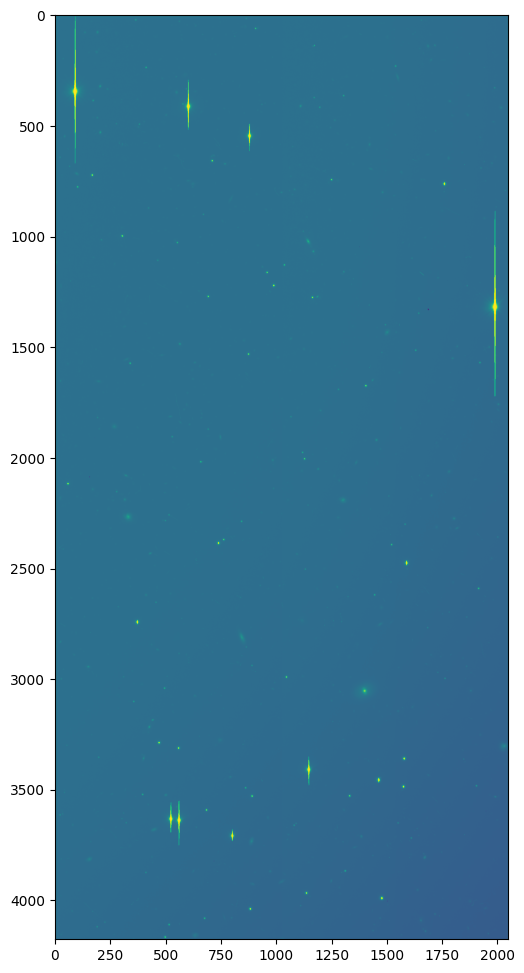

In [11]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(test_im))
plt.show()

In [14]:
test_im.shape[0]

4176

In [16]:
hdr['NAXIS1'] = test_im.shape[1]
hdr['NAXIS2'] = test_im.shape[0]

In [26]:
def get_chips(data):
    chips = []
    chip_len = int(data.shape[1] / 4)
    for i in range(4):
        chips.append(data[:,i*chip_len:(i+1)*chip_len])
    
    return chips

def overscan_subtraction(chips):
    overscan_subbed = []
    counter = 0
    for i in chips:
        h,w = i.shape
        if counter == 0:
            overscan_subbed.append(i[49:int(h) - 48,8:int(w-48)])
        elif counter == 1:
            overscan_subbed.append(i[49:int(h) - 48,48:int(w-8)])
        elif counter == 2:
            overscan_subbed.append(i[49:int(h) - 48,8:int(w-48)])
        elif counter == 3:
            overscan_subbed.append(i[49:int(h) - 48, 48:int(w-8)])
        else:
            print('What have you done to counter?')
            sys.exit()
        counter += 1
    
    return overscan_subbed

def get_width(oss_chips):
    w_tot = 0
    for i in overscan_subbed:
        h, w = i.shape
        w_tot += w
    return h, w_tot

def combine_chips(oss_list, h, w_tot):
    test_im = np.zeros([h, w_tot])
    w_st = 0
    for i in range(4):
        chip = overscan_subbed[i]
        h, w = chip.shape
        test_im[:,w_st:w_st+w] = chip
        w_st += w
    return test_im

In [30]:
for i in tqdm(fits_files):
    filename = os.path.basename(i).replace('.fits','_oss.fits')
    with fits.open(i) as f:
        hdr = f[0].header
        data = f[0].data
    
    chips_list = get_chips(data)
    oss_list = overscan_subtraction(chips_list)
    
    im_dims = get_width(oss_list)
    
    oss_im = combine_chips(oss_list, im_dims[0], im_dims[1])
    
    hdr['NAXIS1'] = oss_im.shape[1]
    hdr['NAXIS2'] = oss_im.shape[0]
    
    fits.writeto(f'C:/Users/oryan/Documents/ngc5907_study/data/overscan-subbed/{filename}', oss_im, hdr)
    
    del data, hdr

100%|██████████| 170/170 [01:29<00:00,  1.90it/s]
